In [1]:
#Librerias utilizadas
import pandas as pd
import numpy as np

#Librerias de visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

#Librerias del modelo KMeans
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#Librerias para graficar en 3D
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (20, 11)
plt.style.use('ggplot')

#Libreria para hacer la reducción PCA
from sklearn.decomposition import PCA

#Librerias para utilizar Dash
from dash import Dash, html, dcc
import plotly.express as px
import plotly.graph_objects as go

In [2]:
dfData = pd.read_csv('Credit Card Customer Data.csv')
dfData.head(3)
#Observamos las 3 primeras filas para conocer los datos que contiene

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4


##### Analizamos y limpiamos los datos para trabajar

In [3]:
print('Tamaño del dataframe creado:', dfData.shape,'\n')
print('Cantidad de vacios por columna'+'\n'+str(dfData.isna().sum())+'\n')
print('Tipo de dato por columna'+'\n'+str(dfData.dtypes))

Tamaño del dataframe creado: (660, 7) 

Cantidad de vacios por columna
Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

Tipo de dato por columna
Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object


Por lo que podemos observar no hay datos vacios y todos todas las columnas son de tipo de dato entero

In [4]:
#Análisis de datos de forma matemática
dfData.describe(include='all')

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,1.000000,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


In [5]:
dfData.size

4620

Aqui podemos ver que un mismo cliente puede tener varias tarjetas

In [6]:
len(dfData['Customer Key'].unique())

655

Pero la vamos a eliminar porque no es relevante para la clasificación ya que se agruparian las del mismo cliente

In [7]:
dfData.drop(['Customer Key', 'Sl_No'], axis=1, inplace=True)

#### Detección de outliers

In [8]:
dfData.columns

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'],
      dtype='object')

Text(0.5, 0.98, 'Gráfica de caja y bigotes de cada columna del dataset')

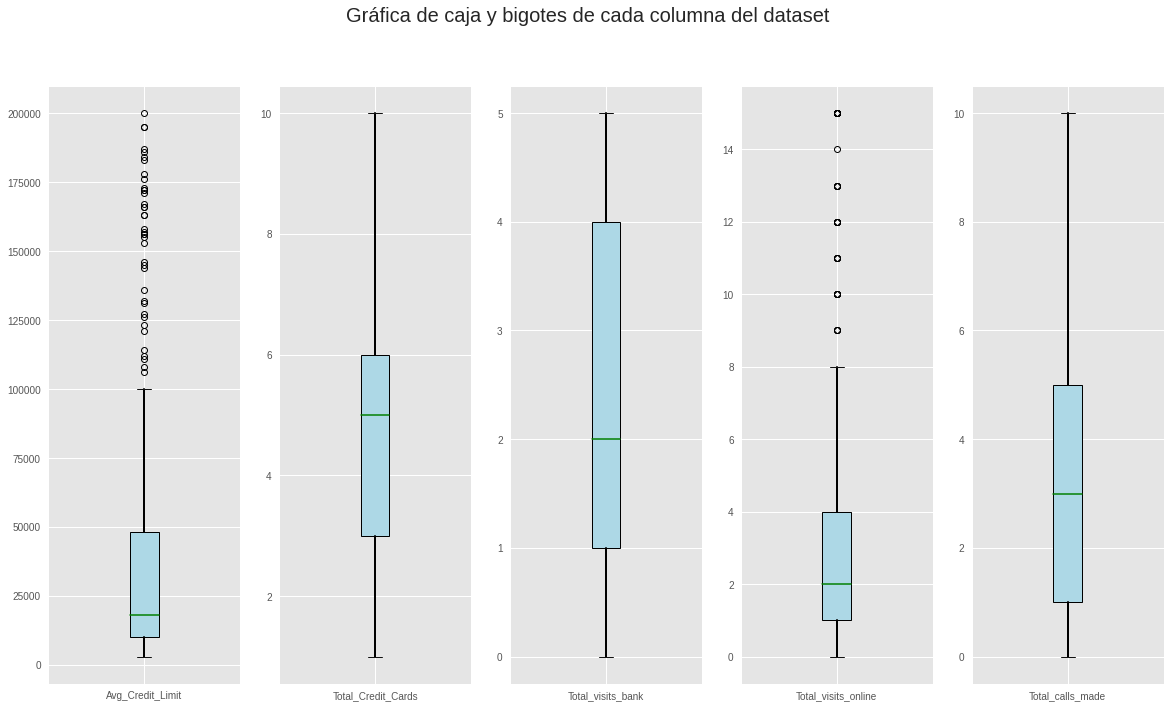

In [9]:
a = ['ax1', 'ax2', 'ax3', 'ax4', 'ax5']
fig, (a) = plt.subplots(1, 5)


for i, column in enumerate(dfData.columns):
    dfData.boxplot(column=[column], ax=a[i], patch_artist = True,
           boxprops = dict(facecolor = "lightblue"), medianprops = dict(color = "green", linewidth = 1.5),
                  whiskerprops = dict(color = "black", linewidth = 2))
    
fig.suptitle('Gráfica de caja y bigotes de cada columna del dataset', size=20)
#plt.savefig("CajaBigote.jpg", bbox_inches='tight')

#Las visualice por separado porque tienen medidas distintas 

In [10]:
#Se crea una función para nornalizar
def normalizar_serie(serie):
    return (serie-min(serie))/(max(serie)-min(serie))

In [11]:
#Aplicamos la normalización a todas las columnas
for column in dfData.columns:
    dfData[column] = normalizar_serie(dfData[column])

In [12]:
#Observamos si funciono la normalizaci
dfData.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,0.492386,0.111111,0.2,0.066667,0.0
1,0.238579,0.222222,0.0,0.666667,0.9
2,0.238579,0.666667,0.2,0.200000,0.4
3,0.137056,0.444444,0.2,0.066667,0.4
4,0.492386,0.555556,0.0,0.800000,0.3


## PCA

In [13]:
#Análisis de datos de forma matemática
dfData.describe(include='all')

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000
mean,0.160275,0.411785,0.480606,0.173737,0.358333
std,0.190992,0.240871,0.326363,0.195715,0.286532
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.035533,0.222222,0.200000,0.066667,0.100000
50%,0.076142,0.444444,0.400000,0.133333,0.300000
75%,0.228426,0.555556,0.800000,0.266667,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
print('Varianza de cada variable')
dfData.var(axis=0)

Varianza de cada variable


Avg_Credit_Limit       0.036478
Total_Credit_Cards     0.058019
Total_visits_bank      0.106513
Total_visits_online    0.038304
Total_calls_made       0.082100
dtype: float64

In [15]:
print('Correlación')
dfCorr = dfData.corr()
dfCorr

Correlación


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_Credit_Limit,1.000000,0.608860,-0.100312,0.551385,-0.414352
Total_Credit_Cards,0.608860,1.000000,0.315796,0.167758,-0.651251
Total_visits_bank,-0.100312,0.315796,1.000000,-0.551861,-0.506016
Total_visits_online,0.551385,0.167758,-0.551861,1.000000,0.127299
Total_calls_made,-0.414352,-0.651251,-0.506016,0.127299,1.000000


Text(0.5, 0.98, 'Mapa de correlación de las variables')

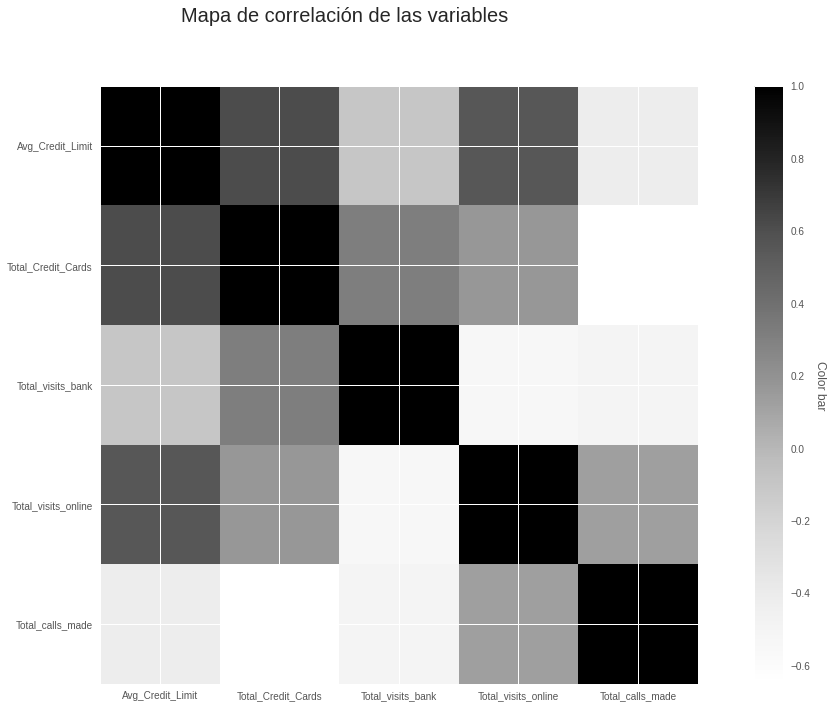

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(dfCorr)

# Agregar las etiquetas
ax.set_xticks(np.arange(len(dfCorr.columns)), labels = dfCorr.columns)
ax.set_yticks(np.arange(len(dfCorr.columns)), labels = dfCorr.columns)

cbar = ax.figure.colorbar(im, ax = ax)
cbar.ax.set_ylabel("Color bar", rotation = -90, va = "bottom")

fig.suptitle('Mapa de correlación de las variables', size=20)
#plt.savefig("MapaCalor.jpg", bbox_inches='tight')

In [17]:
from sklearn.decomposition import PCA
PCA = PCA(n_components=3)
components = PCA.fit_transform(dfData)
PCA.components_

array([[-0.12764791, -0.40109891, -0.66298448,  0.16370947,  0.5970565 ],
       [ 0.50565258,  0.44147427, -0.49143796,  0.48285568, -0.27341373],
       [-0.2217098 , -0.33363437, -0.47455895, -0.34443927, -0.70405132]])

Valores propios la varianza explicada por los tres componentes principales y la varianza explicada acumulada.

In [18]:
cumVar = pd.DataFrame(np.cumsum(PCA.explained_variance_ratio_)*100, 
                      columns=["cumVarPerc"])
expVar = pd.DataFrame(PCA.explained_variance_ratio_*100, columns=["VarPerc"])
pd.concat([expVar, cumVar], axis=1)\
    .rename(index={0: "PC1", 1: "PC2", 2:"PC3"})

,VarPerc,cumVarPerc
PC1,53.403218,53.403218
PC2,30.786704,84.189922
PC3,7.858268,92.048190


El primer componente principal explica un 53.40% de la variación total de los datos originales, mientras que el segundo explica un 30.78% y al final el tercero con un 7.85%

In [19]:
componentsDf = pd.DataFrame(data = components, columns = ['PC1', 'PC2','PC3'])
componentsDf.head()

,PC1,PC2,PC3
0,0.032770,0.219367,0.449011
1,0.788775,0.282010,-0.277186
2,0.102986,0.291307,-0.007615
3,0.183250,0.077486,0.134960
4,0.286272,0.785935,-0.068163


In [20]:
dfInterpretacion = pd.DataFrame(
    data    = PCA.components_,
    columns = dfData.columns, index   = ['PC1', 'PC2', 'PC3'])

dfInterpretacion

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
PC1,-0.127648,-0.401099,-0.662984,0.163709,0.597057
PC2,0.505653,0.441474,-0.491438,0.482856,-0.273414
PC3,-0.221710,-0.333634,-0.474559,-0.344439,-0.704051


In [21]:
PCA.n_components_

3

Text(0.5, 0.98, 'Mapa de relación de variables con la reducción')

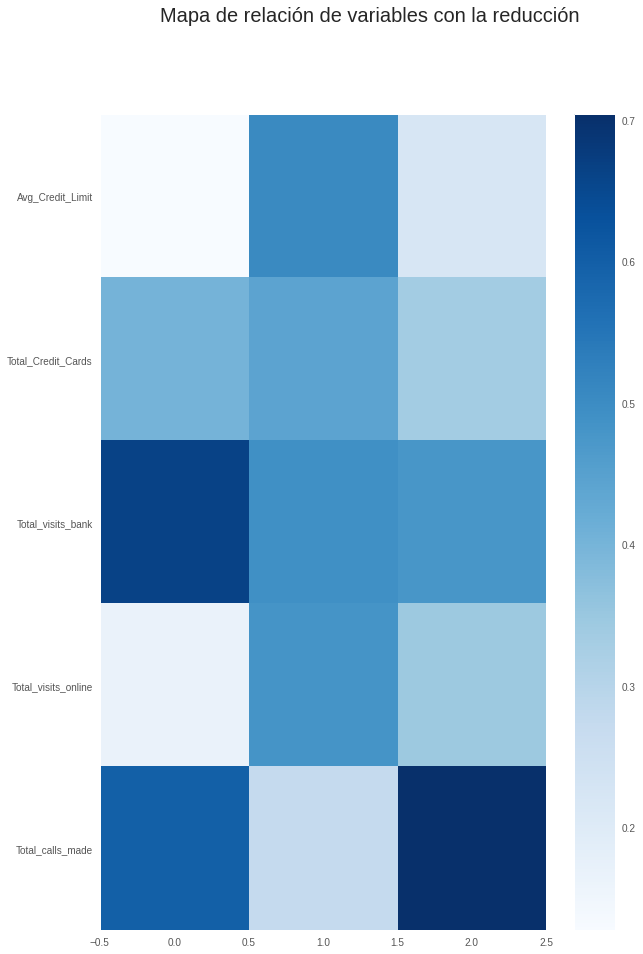

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 15))
componentes = PCA.components_
plt.imshow(abs(componentes.T), cmap='Blues', aspect='auto')
plt.yticks(range(len(dfInterpretacion.columns)), dfInterpretacion.columns)
plt.grid(False)
plt.colorbar()
fig.suptitle('Mapa de relación de variables con la reducción', size=20)
#plt.savefig("MapaCalorReduccion.jpg", bbox_inches='tight')

En la tabla anterior podemos observar la influencia que tuvo cada parametro para que se pudiera reducir

## K-Means

Ahora ya comenzamos con el modelo, lo primero es buscar la k que mas se adapta a los datos

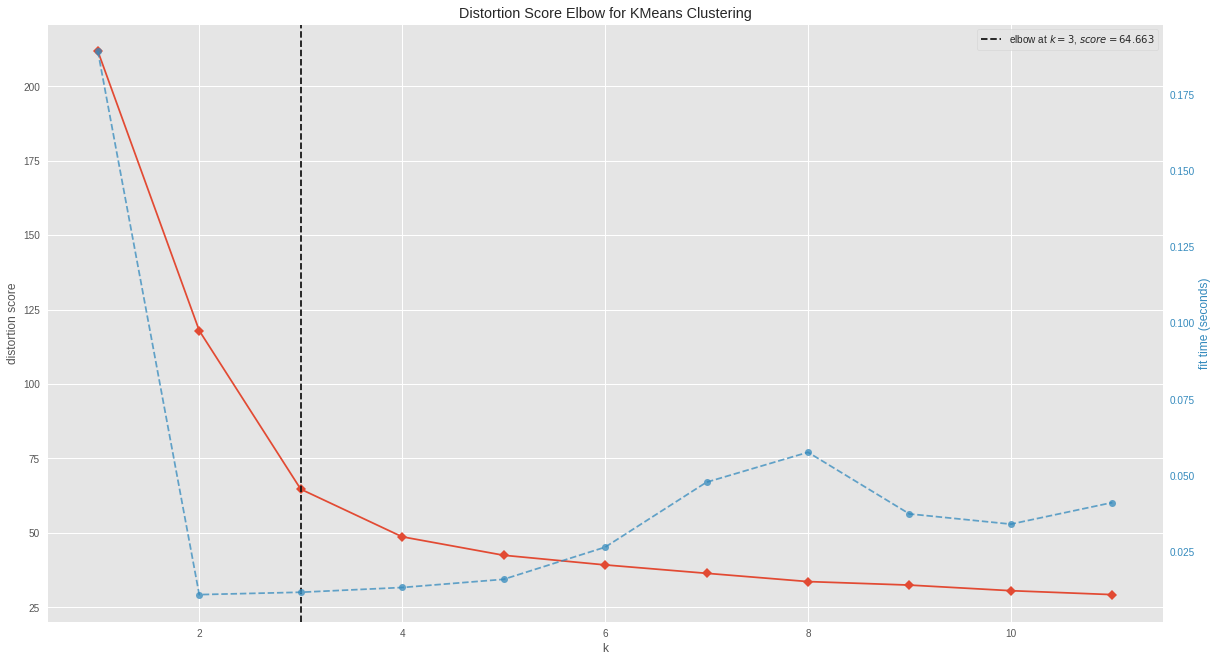

<Figure size 1440x792 with 0 Axes>

In [23]:
model = KMeans()
visualizador = KElbowVisualizer(model, k=(1,12))

visualizador.fit(dfData)# Entrenamos con los datos  
visualizador.show()
plt.savefig("elbow.jpg", bbox_inches='tight')

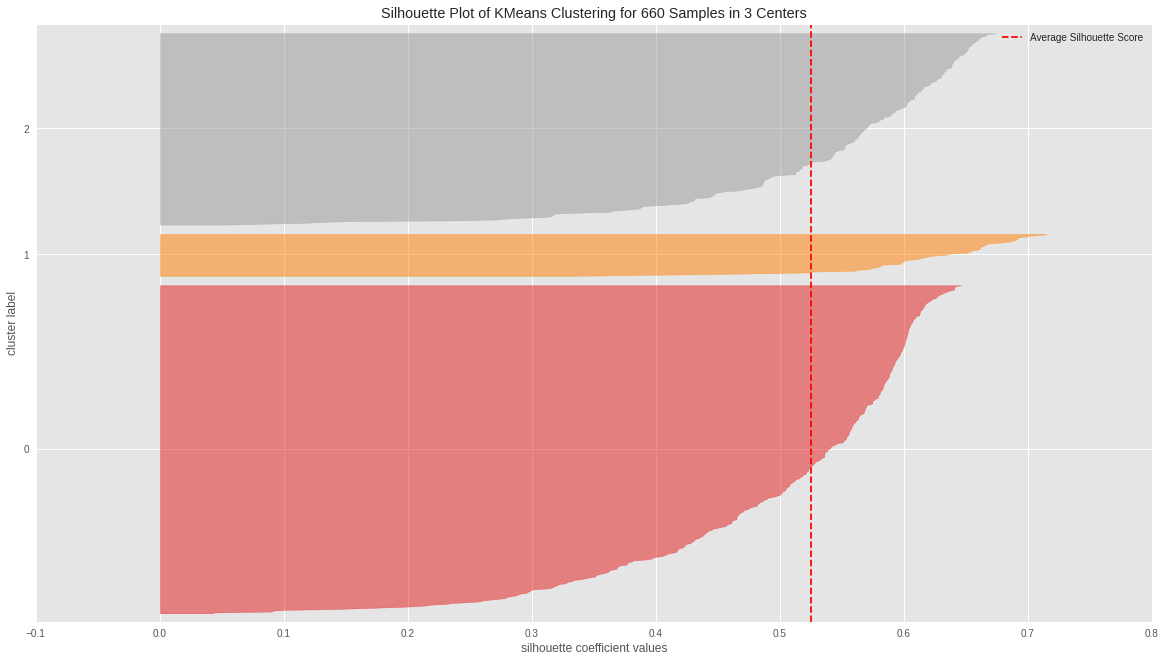

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [24]:
model = KMeans(3)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(dfData)    
visualizer.show()

In [25]:
#Implementramos el algoritmo
kmeans = KMeans(n_clusters=3).fit(componentsDf)
labels = kmeans.predict(componentsDf)
Centroid = kmeans.cluster_centers_
labels_uniques = np.unique(kmeans.labels_)

In [26]:
center = pd.DataFrame(Centroid, columns=componentsDf.columns)

In [27]:
center

,PC1,PC2,PC3
0,0.516843,-0.084260,-0.002759
1,-0.293138,-0.078522,0.016214
2,-0.068631,0.983793,-0.112434


In [28]:
Centroid

array([[ 0.51684314, -0.08426038, -0.00275922],
       [-0.29313803, -0.07852228,  0.01621436],
       [-0.06863134,  0.98379324, -0.11243411]])

Text(0.5, 0, 'PC3')

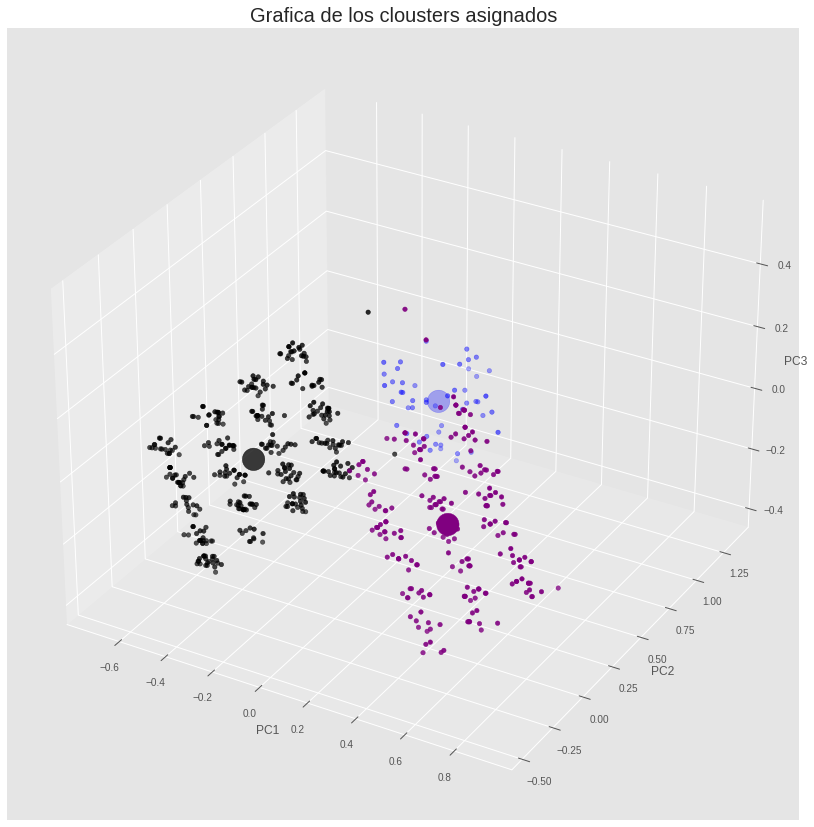

In [29]:
colors=['purple','black','blue']
add_color=[]
for row in labels:
    add_color.append(colors[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(componentsDf['PC1'], componentsDf['PC2'], componentsDf['PC3'], c=add_color, s=20)
ax.scatter(Centroid[:, 0], Centroid[:, 1], Centroid[:, 2], marker='o', c=colors, s=500)
ax.set_title("Grafica de los clousters asignados", size=20)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
#plt.savefig("grafica3d.jpg", bbox_inches='tight')

In [30]:
dfAux = componentsDf.copy(deep = True)
dfAux['Cluster'] = kmeans.labels_
dfAux.head()

,PC1,PC2,PC3,Cluster
0,0.032770,0.219367,0.449011,1
1,0.788775,0.282010,-0.277186,0
2,0.102986,0.291307,-0.007615,1
3,0.183250,0.077486,0.134960,0
4,0.286272,0.785935,-0.068163,2


In [31]:
np.unique(kmeans.labels_, return_counts=True) 

(array([0, 1, 2], dtype=int32), array([225, 385,  50]))

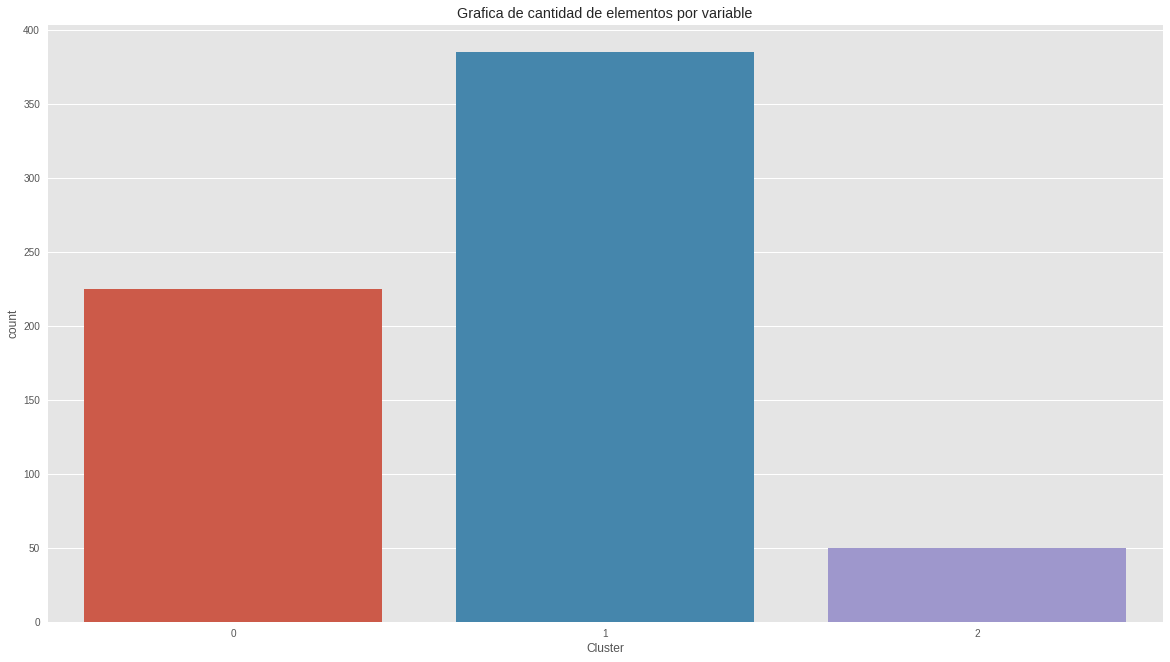

In [32]:
sns_plot = sns.countplot(x='Cluster',data=dfAux).set(title='Grafica de cantidad de elementos por variable')
plt.savefig('EleVar1.png')

## Dash

In [33]:
componentsDf['clousters'] = labels 

In [34]:
componentsDf

,PC1,PC2,PC3,clousters
0,0.032770,0.219367,0.449011,1
1,0.788775,0.282010,-0.277186,0
2,0.102986,0.291307,-0.007615,1
3,0.183250,0.077486,0.134960,0
4,0.286272,0.785935,-0.068163,2
...,...,...,...,...
655,-0.224888,0.898935,-0.053091,2
656,-0.063016,0.902322,-0.245907,2
657,-0.116770,0.859369,-0.078162,2
658,-0.217620,1.247261,-0.250060,2


In [35]:
app = Dash(__name__)

colors=['purple','black','blue']

add_color=[]
for row in labels:
    add_color.append(colors[row])


fig = go.Figure()

fig.add_trace(go.Scatter3d(x=componentsDf['PC1'], y=componentsDf['PC2'], z=componentsDf['PC3'], 
                           mode='markers', marker = dict(size=3, color=add_color),  name= 'Punto'))

fig.add_trace(go.Scatter3d(x=Centroid[:, 0], y=Centroid[:, 1], z=Centroid[:, 2], mode='markers', marker= dict(size=10,color=colors), name = 'Centroide'))

fig.update_layout(scene = dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),
                    #legend_title="Tipo de punto"),
                    width=800,
                    margin=dict(r=20, b=10, l=10, t=10))



fig2 = px.histogram(componentsDf, x='clousters', color_discrete_sequence=['purple'])

fig3 = px.imshow(dfInterpretacion, text_auto=True)



app.layout = html.Div(children=[
    
    html.H1(children='Visualización de agrupamiento con KMeans para identificar clientes leales con base a sus tarjetas de crédito', style = {'textAlign':'center',\
                                            'marginTop':40,'marginBottom':40, 'background-color':'#2471A3', 'color':'white', 'font-family':'Sans-Serif'}),
    
    html.H2(children='Gráfica de los clousters asignados'),
    
    dcc.Graph(
        id='3d',
        figure=fig
    ),
    
    html.H2(children='Conteo de personas asignadas a cada categoría'),
    
    dcc.Graph(
        id='bar',
        figure=fig2
    ),

    html.H2(children='Interpretación de las variables'),

    dcc.Graph(
        id='heatmap',
        figure=fig3),
    
    html.H4(children='La interpretación de este mapa de calor es para que se pueda obtener información sobre que significa \'x\',\'y\' y \'z\' en la grafica 3d con cada uno de las variables que se encuentran en el dataset, entre mas grande sea el valor significa que se extrajo mas información de esta.',
           style = {'textAlign':'center',\
                                            'marginTop':40,'marginBottom':60, 'marginLeft':80, 'marginRight':80, 'background-color':'purple', 'color':'white', 'font-family':'Sans-Serif'})
    
])

if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)